In [89]:
# Math 
from math import sqrt
from scipy import stats
import statistics
import os

# General
import numpy as np
import pandas as pd

# Sklearn Modeling
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
import sklearn.preprocessing

# Visuals
import matplotlib.pyplot as plt
import seaborn as sns
from graphviz import Graph
from tabulate import tabulate

# Custom Module's

from wrangle import wrangle_zillow

from pydataset import data

import evaluate
import warnings
warnings.filterwarnings("ignore")

### Select a dataset with a continuous target variable.

In [105]:
train, validate, test = wrangle_zillow()

### Be sure your data is prepared (no missing values, numeric datatypes) and split into samples.

In [106]:
train.head(3)

,bedrooms,bathrooms,area,tax_value,year_built,fips
10057,4.0,2.0,1561.0,248240.0,1973,6059
2004970,3.0,2.0,1770.0,88390.0,1960,6037
306031,2.0,1.0,1452.0,81169.0,1946,6037


### Work through all of the steps outlined in the lesson, from setting the baseline to selected a model and evaluating the final model on your test data.

In [107]:
X_train = train[["bedrooms", "bathrooms", "area"]]
y_train = train["tax_value"]

X_validate = validate[["bedrooms", "bathrooms", "area"]]
y_validate = validate[["tax_value"]]

X_test = test[["bedrooms", "bathrooms", "area"]]
y_test= test["tax_value"]

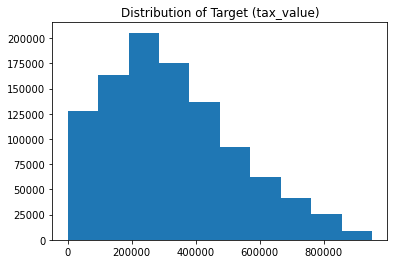

In [108]:
plt.hist(y_train)
plt.title('Distribution of Target (tax_value)')
plt.show()

In [109]:
y_train  = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [110]:
y_train.head()
y_train.tax_value.idxmax()

2054729

In [111]:
# Mean
mean = y_train.tax_value.mean() # Train Mean
y_train['tax_value_pred_mean'] = mean
y_validate['tax_value_pred_mean'] = mean

In [112]:
# Median
median = y_train.tax_value.median() # Train Median
y_train['tax_value_pred_median'] = median
y_validate['tax_value_pred_median'] = median

In [113]:
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_mean) ** .5
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_mean) ** (1/2)

rmse_train, rmse_validate

(198987.47875695032, 198712.68534357747)

In [114]:
def make_metric_df(y, y_pred, model_name, metric_df):
    if metric_df.size ==0:
        metric_df = pd.DataFrame(data=[
            {
                'model': model_name, 
                'RMSE_validate': mean_squared_error(
                    y,
                    y_pred) ** .5,
                'r^2_validate': explained_variance_score(
                    y,
                    y_pred)
            }])
        return metric_df
    else:
        return metric_df.append(
            {
                'model': model_name, 
                'RMSE_validate': mean_squared_error(
                    y,
                    y_pred) ** .5,
                'r^2_validate': explained_variance_score(
                    y,
                    y_pred)
            }, ignore_index=True)

In [115]:
# create the metric_df as a blank dataframe
metric_df = pd.DataFrame()
# make our first entry into the metric_df with median baseline
metric_df = make_metric_df(y_validate.tax_value,
                           y_validate.tax_value_pred_median,
                           'median_baseline',
                          metric_df)

In [116]:
metric_df

,model,RMSE_validate,r^2_validate
0,median_baseline,201109.241172,0.0


In [117]:
metric_df = make_metric_df(y_validate.tax_value,
                           y_validate.tax_value_pred_mean,
                           'mean_baseline',
                          metric_df)

In [118]:
metric_df

,model,RMSE_validate,r^2_validate
0,median_baseline,201109.241172,0.0
1,mean_baseline,198712.685344,0.0


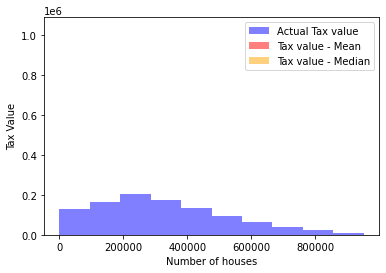

In [119]:
# plot to visualize actual vs predicted. 
plt.hist(y_train.tax_value, color='blue', alpha=.5, label="Actual Tax value")
plt.hist(y_train.tax_value_pred_mean, bins=1, color='red', alpha=.5, rwidth=100, label="Tax value - Mean")
plt.hist(y_train.tax_value_pred_median, bins=1, color='orange', alpha=.5, rwidth=100, label="Tax value - Median")
plt.xlabel("Number of houses")
plt.ylabel("Tax Value")
plt.legend()
plt.show()

In [120]:
lm = LinearRegression(normalize=True)
lm.fit(X_train, y_train.tax_value)

LinearRegression(normalize=True)

In [121]:
y_train['tax_value_pred_lm'] = lm.predict(X_train)

In [122]:
# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm) ** (1/2)

# predict validate
y_validate['tax_value_pred_lm'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm) ** (1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  179364.61633346934 
Validation/Out-of-Sample:  179181.94999039287


In [123]:
metric_df = metric_df.append({
    'model': 'OLS Regressor', 
    'RMSE_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.tax_value, y_validate.tax_value_pred_lm)}, ignore_index=True)

In [124]:
metric_df

,model,RMSE_validate,r^2_validate
0,median_baseline,201109.241172,0.000000
1,mean_baseline,198712.685344,0.000000
2,OLS Regressor,179181.949990,0.186912


In [131]:
# create the model object
lars = LassoLars(alpha=3)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series!
lars.fit(X_train, y_train.tax_value)

# predict train
y_train['tax_value_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lars) ** (1/2)

# predict validate
y_validate['tax_value_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lars) ** (1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  179512.9872926957 
Validation/Out-of-Sample:  179324.93148291844


In [134]:
metric_df = make_metric_df(y_validate.tax_value,
               y_validate.tax_value_pred_lars,
               'lasso_alpha_3',
               metric_df)

In [136]:
metric_df.RMSE_validate.idxmin()

2

In [137]:
metric_df

,model,RMSE_validate,r^2_validate
0,median_baseline,201109.241172,0.000000
1,mean_baseline,198712.685344,0.000000
2,OLS Regressor,179181.949990,0.186912
3,lasso_alpha_1,179196.727454,0.186778
4,lasso_alpha_2,179244.396695,0.186345
5,lasso_alpha_2,179324.931483,0.185614
6,lasso_alpha_3,179324.931483,0.185614


In [138]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)


# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train.tax_value)

# predict train
y_train['tax_value_pred_glm'] = glm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_glm) ** (1/2)

# predict validate
y_validate['tax_value_pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_glm) ** (1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  198987.47875695032 
Validation/Out-of-Sample:  198712.68534357747


In [139]:
make_metric_df(y_validate.tax_value,
               y_validate.tax_value_pred_glm,
               'glm_poisson',
               metric_df)

,model,RMSE_validate,r^2_validate
0,median_baseline,201109.241172,0.000000e+00
1,mean_baseline,198712.685344,0.000000e+00
2,OLS Regressor,179181.949990,1.869118e-01
3,lasso_alpha_1,179196.727454,1.867777e-01
4,lasso_alpha_2,179244.396695,1.863451e-01
5,lasso_alpha_2,179324.931483,1.856138e-01
6,lasso_alpha_3,179324.931483,1.856138e-01
7,glm_poisson,198712.685344,-4.440892e-16


In [140]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 =  pf.transform(X_test)

In [141]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.tax_value)

# predict train
y_train['tax_value_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm2) ** (1/2)

# predict validate
y_validate['tax_value_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm2) ** 0.5

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  179277.9129146557 
Validation/Out-of-Sample:  179093.02292881504


In [142]:
metric_df = make_metric_df(y_validate.tax_value,
               y_validate.tax_value_pred_lm2,
               'quadratic',
               metric_df)

In [143]:
metric_df

,model,RMSE_validate,r^2_validate
0,median_baseline,201109.241172,0.000000
1,mean_baseline,198712.685344,0.000000
2,OLS Regressor,179181.949990,0.186912
3,lasso_alpha_1,179196.727454,0.186778
4,lasso_alpha_2,179244.396695,0.186345
5,lasso_alpha_2,179324.931483,0.185614
6,lasso_alpha_3,179324.931483,0.185614
7,quadratic,179093.022929,0.187719


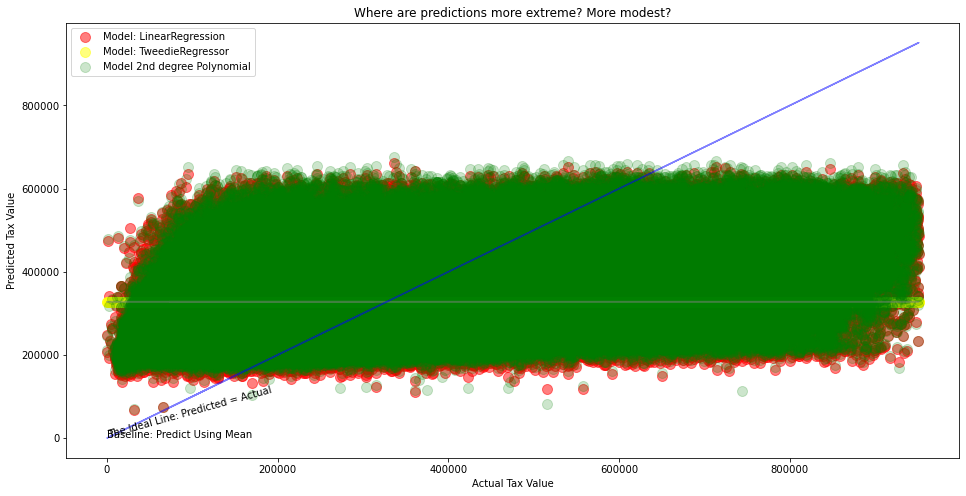

In [150]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(y_validate.tax_value, y_validate.tax_value_pred_mean, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.plot(y_validate.tax_value, y_validate.tax_value, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_glm, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm2, 
            alpha=.2, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Predicted Tax Value")
plt.title("Where are predictions more extreme? More modest?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

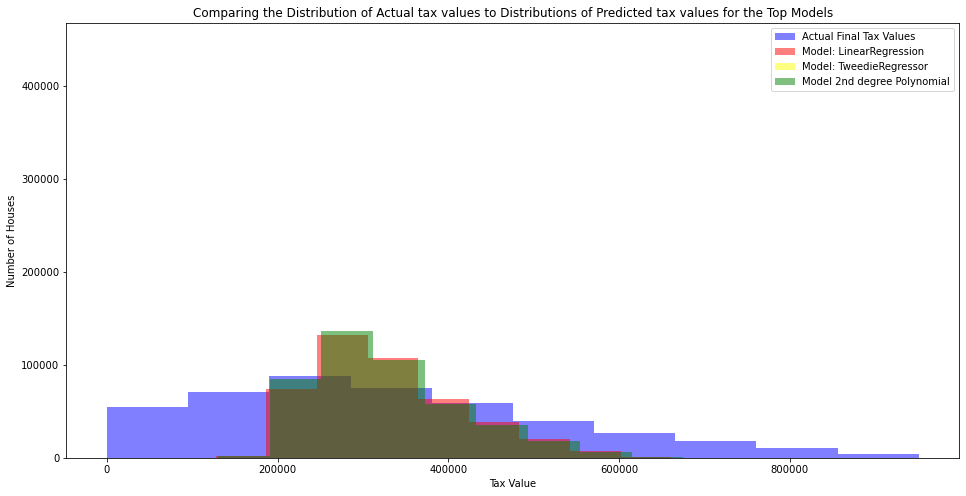

In [146]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))
plt.hist(y_validate.tax_value, color='blue', alpha=.5, label="Actual Final Tax Values")
plt.hist(y_validate.tax_value_pred_lm, color='red', alpha=.5, label="Model: LinearRegression")
plt.hist(y_validate.tax_value_pred_glm, color='yellow', alpha=.5, label="Model: TweedieRegressor")
plt.hist(y_validate.tax_value_pred_lm2, color='green', alpha=.5, label="Model 2nd degree Polynomial")
plt.xlabel("Tax Value")
plt.ylabel("Number of Houses")
plt.title("Comparing the Distribution of Actual tax values to Distributions of Predicted tax values for the Top Models")
plt.legend()
plt.show()

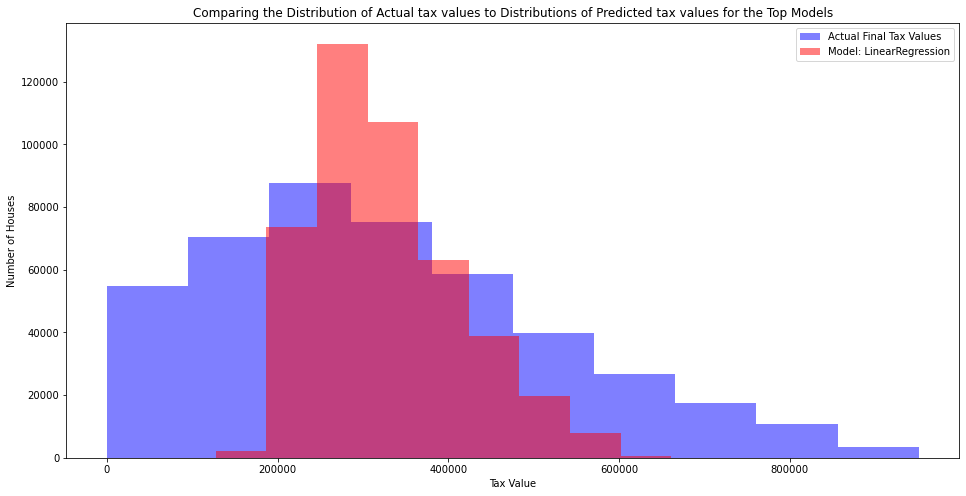

In [147]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))
plt.hist(y_validate.tax_value, color='blue', alpha=.5, label="Actual Final Tax Values")
plt.hist(y_validate.tax_value_pred_lm, color='red', alpha=.5, label="Model: LinearRegression")
#plt.hist(y_validate.tax_value_pred_glm, color='yellow', alpha=.5, label="Model: TweedieRegressor")
#plt.hist(y_validate.tax_value_pred_lm2, color='green', alpha=.5, label="Model 2nd degree Polynomial")
plt.xlabel("Tax Value")
plt.ylabel("Number of Houses")
plt.title("Comparing the Distribution of Actual tax values to Distributions of Predicted tax values for the Top Models")
plt.legend()
plt.show()

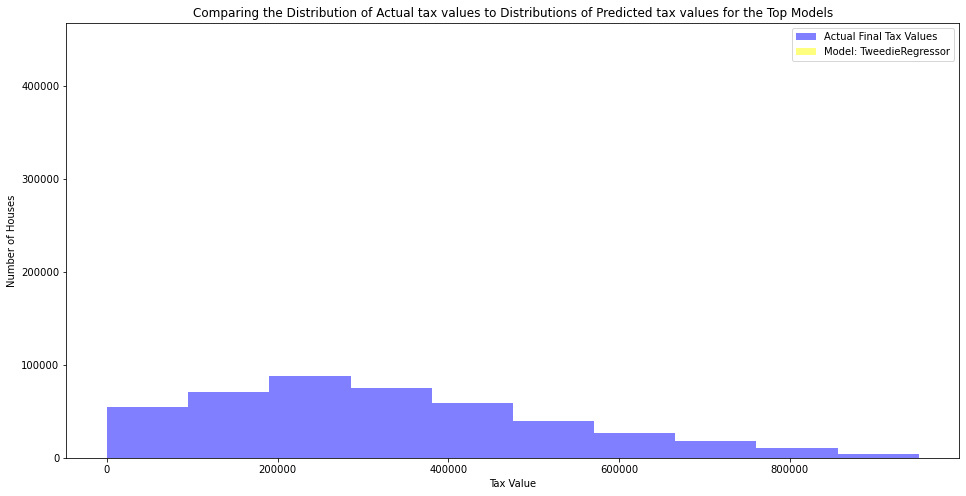

In [148]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))
plt.hist(y_validate.tax_value, color='blue', alpha=.5, label="Actual Final Tax Values")
#plt.hist(y_validate.tax_value_pred_lm, color='red', alpha=.5, label="Model: LinearRegression")
plt.hist(y_validate.tax_value_pred_glm, color='yellow', alpha=.5, label="Model: TweedieRegressor")
#plt.hist(y_validate.tax_value_pred_lm2, color='green', alpha=.5, label="Model 2nd degree Polynomial")
plt.xlabel("Tax Value")
plt.ylabel("Number of Houses")
plt.title("Comparing the Distribution of Actual tax values to Distributions of Predicted tax values for the Top Models")
plt.legend()
plt.show()

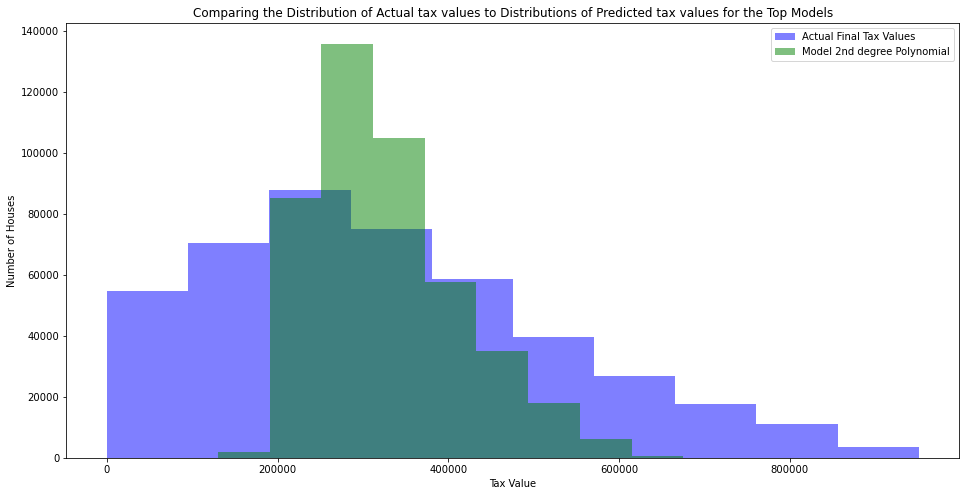

In [149]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))
plt.hist(y_validate.tax_value, color='blue', alpha=.5, label="Actual Final Tax Values")
#plt.hist(y_validate.tax_value_pred_lm, color='red', alpha=.5, label="Model: LinearRegression")
#plt.hist(y_validate.tax_value_pred_glm, color='yellow', alpha=.5, label="Model: TweedieRegressor")
plt.hist(y_validate.tax_value_pred_lm2, color='green', alpha=.5, label="Model 2nd degree Polynomial")
plt.xlabel("Tax Value")
plt.ylabel("Number of Houses")
plt.title("Comparing the Distribution of Actual tax values to Distributions of Predicted tax values for the Top Models")
plt.legend()
plt.show()